# Домашняя работа №3
## Студент: Трофимов Иван Александрович
## группа: М8О-111М-19

## Задача №1: Реализовать понижение размерности исходных данных при помощи метода РСА
### В качестве исходных данных был выбран датасет, содержащий информацию о графическом изображении букв латинского алфавита. Информация выражена в ряде определенных коэффициентов (16 параметров), отвечающих за наклон, размер и т. д. Задачей классификации является установление по данным числовым характеристикам символ, за который они отвечают. Выборка содержит 20 000 строк с различными вариантами написания символов A-Z с использованием различных шрифтов. Числовые параметры каждого символа содержатся в 16 столбцах исходной таблицы.

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

from time import time

In [46]:
'''Attribute Information:
	 1.	lettr	capital letter	(26 values from A to Z)
	 2.	x-box	horizontal position of box	(integer)
	 3.	y-box	vertical position of box	(integer)
	 4.	width	width of box			(integer)
	 5.	high 	height of box			(integer)
	 6.	onpix	total # on pixels		(integer)
	 7.	x-bar	mean x of on pixels in box	(integer)
	 8.	y-bar	mean y of on pixels in box	(integer)
	 9.	x2bar	mean x variance			(integer)
	10.	y2bar	mean y variance			(integer)
	11.	xybar	mean x y correlation		(integer)
	12.	x2ybr	mean of x * x * y		(integer)
	13.	xy2br	mean of x * y * y		(integer)
	14.	x-ege	mean edge count left to right	(integer)
	15.	xegvy	correlation of x-ege with y	(integer)
	16.	y-ege	mean edge count bottom to top	(integer)
	17.	yegvx	correlation of y-ege with x	(integer)'''

column_names = ['lettr','x-box','y-box','width','high','onpix','x-bar',
                'y-bar','x2bar','y2bar','xybar','x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx']
df = pd.read_csv('letter-recognition.data', sep=',', names = column_names)
print(df.head())
Y = df['lettr']
X = df.drop(columns = 'lettr')

  lettr  x-box  y-box  width  high  onpix  x-bar  y-bar  x2bar  y2bar  xybar  \
0     T      2      8      3     5      1      8     13      0      6      6   
1     I      5     12      3     7      2     10      5      5      4     13   
2     D      4     11      6     8      6     10      6      2      6     10   
3     N      7     11      6     6      3      5      9      4      6      4   
4     G      2      1      3     1      1      8      6      6      6      6   

   x2ybr  xy2br  x-ege  xegvy  y-ege  yegvx  
0     10      8      0      8      0      8  
1      3      9      2      8      4     10  
2      3      7      3      7      3      9  
3      4     10      6     10      2      8  
4      5      9      1      7      5     10  


### таблица корреляции для исходных данных

In [47]:
X.corr()

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
x-box,1.000000,0.757793,0.851514,0.672764,0.619097,-0.032595,0.045545,0.014306,0.052086,0.148056,0.035464,-0.046333,0.489155,0.098180,0.273504,-0.105147
y-box,0.757793,1.000000,0.671912,0.823207,0.555067,0.045690,-0.040925,-0.025019,0.096478,0.159954,-0.054648,-0.007568,0.274431,-0.001336,0.230883,-0.042741
width,0.851514,0.671912,1.000000,0.660215,0.765716,0.061959,0.024832,-0.098611,0.057074,0.115018,0.011694,-0.045009,0.557251,0.045658,0.260285,-0.118273
high,0.672764,0.823207,0.660215,1.000000,0.644366,0.042844,-0.020072,0.082383,0.059032,0.012458,-0.011991,0.026386,0.265243,0.025359,0.297545,-0.018853
onpix,0.619097,0.555067,0.765716,0.644366,1.000000,0.139159,-0.028822,-0.011985,-0.065557,-0.069776,-0.072941,-0.038858,0.627507,0.017649,0.492653,-0.062969
x-bar,-0.032595,0.045690,0.061959,0.042844,0.139159,1.000000,-0.356580,-0.053306,-0.122851,0.085963,-0.341957,-0.032115,0.144325,-0.253339,0.127056,0.248816
y-bar,0.045545,-0.040925,0.024832,-0.020072,-0.028822,-0.356580,1.000000,-0.118625,-0.049658,0.178318,0.600397,-0.271649,-0.036722,0.555060,-0.078008,-0.207900
x2bar,0.014306,-0.025019,-0.098611,0.082383,-0.011985,-0.053306,-0.118625,1.000000,-0.188431,-0.317780,0.042545,0.082020,0.142132,-0.084820,0.006546,0.182902
y2bar,0.052086,0.096478,0.057074,0.059032,-0.065557,-0.122851,-0.049658,-0.188431,1.000000,0.132000,-0.060116,0.119048,-0.384018,-0.052545,0.277540,-0.061335
xybar,0.148056,0.159954,0.115018,0.012458,-0.069776,0.085963,0.178318,-0.317780,0.132000,1.000000,0.057988,-0.106759,-0.175676,0.029419,-0.087019,-0.114223


### HeatMap для исходных данных

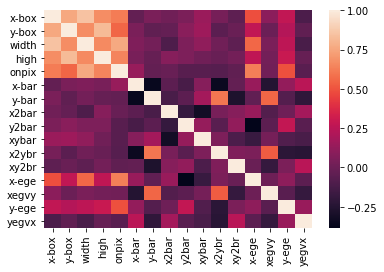

In [48]:
sns.heatmap(X.corr())

### Из этих результатов видно, что в исходных данных существуют довольно сильно скоррелированные величниы, а значит имеет смысл применение методов понижения размерности
### Далее, для демонстрация будет несколько раз оценена точность работы алгоритма после понижения размерности, кол-во иоговых столбцов будет изменяться от 16(исходные данные -1) до 1
### Для оценки точности будет использоваться процедура кросс-валидации (n=4)

In [ ]:
def PCA_algorithm

In [68]:
mean_accuracy_list = []
timers = []
for PCA_counter in range(16,0,-1):
    start_t = time()
    X_reduced = PCA(n_components = PCA_counter).fit_transform(X)
    #x_train, x_test, y_train, y_test = train_test_split(X_reduced ,Y, test_size = 0.25, random_state = 1)
    mean_accuracy = cross_val_score(estimator=DecisionTreeClassifier(), X=X_reduced, y=Y, cv=4, scoring='accuracy').sum()/4
    timer = time() - start_t
    mean_accuracy_list.append(mean_accuracy)
    timers.append(timer)
    print('кол-во столбцев:', PCA_counter, 'средняя точность:', mean_accuracy, 'время работы:',timer,'сек.')

кол-во столбцев: 16 средняя точность: 0.7817944336910867 время работы: 4.394251585006714 сек.
кол-во столбцев: 15 средняя точность: 0.7839436959476308 время работы: 2.399137020111084 сек.
кол-во столбцев: 14 средняя точность: 0.7872421312014877 время работы: 1.9611122608184814 сек.
кол-во столбцев: 13 средняя точность: 0.7878432802702638 время работы: 1.8351049423217773 сек.
кол-во столбцев: 12 средняя точность: 0.7872952281129 время работы: 1.8031032085418701 сек.
кол-во столбцев: 11 средняя точность: 0.7868411874658512 время работы: 1.6490943431854248 сек.
кол-во столбцев: 10 средняя точность: 0.7829944233032942 время работы: 1.5370879173278809 сек.
кол-во столбцев: 9 средняя точность: 0.7770958398824102 время работы: 2.4431400299072266 сек.
кол-во столбцев: 8 средняя точность: 0.7678942135824629 время работы: 2.0921196937561035 сек.
кол-во столбцев: 7 средняя точность: 0.7533859994983513 время работы: 1.4660840034484863 сек.
кол-во столбцев: 6 средняя точность: 0.7283936162865375 вр

### Построим графики зависимостей точности работы алгоритма и времени работы от колличества столбцев после понижения размерности выборки

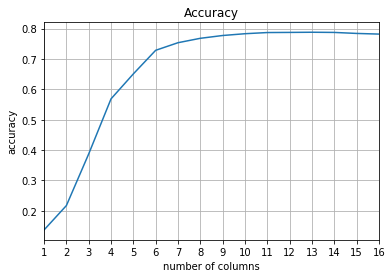

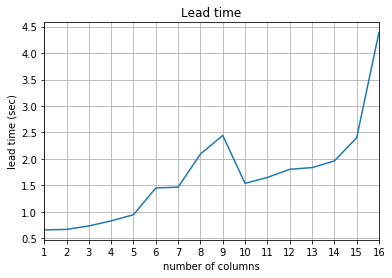

In [118]:
plt.figure()
plt.plot(range(16,0,-1),mean_accuracy_list)
plt.xlabel('number of columns')
plt.xlim([1, 16])
plt.xticks(range(16,0,-1))
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.grid()
plt.show()
plt.figure()
plt.plot(range(16,0,-1),timers)
plt.xlabel('number of columns')
plt.xlim([1, 16])
plt.xticks(range(16,0,-1))
plt.ylabel('lead time (sec)')
plt.title('Lead time')
plt.grid()
plt.show()

### Из данных графиков видно, что уменьшение количества столбцев в данных сильно влияет на время работы алгоритма, в то-же время, до некоторого определенного значения, точность остается на приемлимом относительно исходных данных уровне (т.к. существуют сильно зависимые величины). Из чего можно сделать вывод, что для данной выборки оправдано применение процедуру понижения размерности.

## Задание №2. Бинарная классификация, ROC - кривая

### В качестве исходных данных взята статистика по пассажирам корабля "Титаник". классификация по параметру "спасся / погиб"

In [94]:
data = pd.read_csv('train_and_test2.csv')
data=data.drop(columns=['zero'])
for i in range(1,19):
    data = data.drop(columns=['zero.'+str(i)])
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
print(data.head())
X = np.array(data.drop(columns=['Passengerid','2urvived']))
y = np.array(data['2urvived'] == 0)
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.25, random_state = 1)

   Passengerid   Age     Fare  Sex  sibsp  Parch  Pclass  Embarked  2urvived
0            1  22.0   7.2500    0      1      0       3       2.0         0
1            2  38.0  71.2833    1      1      0       1       0.0         1
2            3  26.0   7.9250    1      0      0       3       2.0         1
3            4  35.0  53.1000    1      1      0       1       2.0         1
4            5  35.0   8.0500    0      0      0       3       2.0         0


In [98]:
clf = svm.SVC(gamma = 'auto')
y_sc = clf.fit(x_train, y_train).decision_function(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_sc)
roc_auc = auc(fpr, tpr)
Auc = roc_auc_score(y_test, y_sc)
print(Auc)

0.7445219123505976


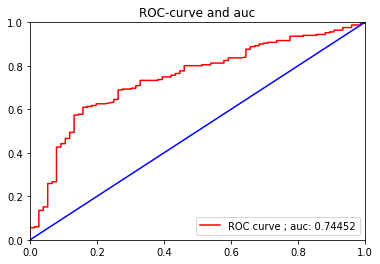

In [122]:
plt.plot(fpr, tpr, color='red', label='ROC curve ; auc: %0.5f' % Auc)
plt.plot([0, 1], [0, 1], color='blue')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC-curve and auc')
plt.legend(loc="lower right")
plt.show()